# Localization with a known map &mdash; Part 1 <br/> Key Components of the Model
<!-- Key Components of the Model -->
<!-- Introduction to Localization with Known Map: Modeling and Key Components -->

Throughout this tutorial, we aim to equip you with the knowledge and practical insights required to tackle the challenges of SLAM and effectively localize a robot in complex environments.
    
In this series of tutorials, we explore a simplified version of the SLAM problem: *Localization using a known map*. Here the map is represented as a collection of line segments. Furthermore, we will explore an optional feature that allows the environment to be cluttered with additional boxes that are not included in the map, creating what we refer to as an "idealized" map.

To begin, we will break down the localization model into its key components: 

- The pose prior, which provides an initial estimate of the robot's position. 
- The control prior, which characterizes the intended motion of the robot.  
- The motion model, which describes how the robot's position evolves over time based on its past position and the control. 
- Lastly, we will delve into the sensor model, which enables the robot to perceive its surroundings.

The sensor model will be presented in two versions. 
- First, we will introduce a "plug-and-play" approach utilizing Gen distributions, as well as Gen's Mixture and Product Distribution types, offering flexibility and ease of implementation. 
- Subsequently, we will showcase a performance-optimized version that employs a custom Gen distribution, maximizing performance.

...

**Notation and naming conventions** 

I usually try to keep variable naming concise and closer to the conventions found in mathematical papers, rather than those used in software engineering. I find that adopting this approach makes it easier to comprehend research code. However, it is essential to provide additional notes or documentation to provide context for interpreting variable names.

```julia
    x              = rand(2)  # Preferred
    agent_position = rand(2)  # Sometimes OK as well

    ỹ = sliding_windows(y, 10, 1)                      # Preferred
    sliding_windows_over_y = sliding_windows(y, 10, 1) # Hard to parse
```

In line with this practice, I make an effort to indicate CUDA arrays by appending a trailing underscore. For example, if we have an array `x`, its CUDA version would be denoted as `x_`:

```julia
    x  = rand(100,100)
    x_ = CuArray(x)
```

Following a Python-inspired convention, I use addional underscores for contants or varibales that are not supposed to change. This allows me to reuse descriptive names without conflicting with constant values. Consequently, I can employ these informative names directly in the code that follows, ensuring clarity and readability.

```julia
    ps = [ p+u for (p, u) in zip(_ps, _us) ]
```

In [1]:
# This is a fix for vscode, because it doesn't like my
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [2]:
#nbx --fname="src/localization_part_1.jl"
push!(LOAD_PATH, "../src");
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");
using BenchmarkTools;
using CUDA
using LaTeXStrings
using Colors, Plots, Images;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using Fmt: @f_str, format # Python-style f-strings
using MyUtils
using StatsBase: mean
using Random: shuffle
using Geometry: Segment
include("../src/pose.jl");
include("src/plotting.jl");

using GenDistributionZoo: ProductDistribution, diagnormal
mvuniform = ProductDistribution(uniform);

We included a bunch of stuff there including:
 - `Pose(x,hd)` and `Control(dx, dhd)` types (with plenty of convenient methods to process them) ,
 - Just some plotting stuff that is useful later.
 - ...





## Ground Truth and Task Input -- What are we trying to solve

Our SLAM model needs data to run on.
 By running the cell below we include a bunch of variables including: 
 - ground truth poses `_ps`, 
 - ground truth controls `_us`, 
 - the line segments forming the environment `_segs`,
 - ...



### Load environment and path data

In [3]:
#nbx
# Load the environment and poses
include("src/house_expo_data.jl");

Loading data from `../data/data_4.jld2`, and
populating Main namespace with variables:

_segs      Vector{Segment}
_boxes     Vector{Segment}
_center    Vector{Float64}
_xs        Vector{Vector{Float64}}
_hds       Vector{Float64}
_ps        Vector{Pose}
_dxs       Vector{Vector{Float64}}
_dhds      Vector{Float64}
_us        Vector{Control}
_T         Int64


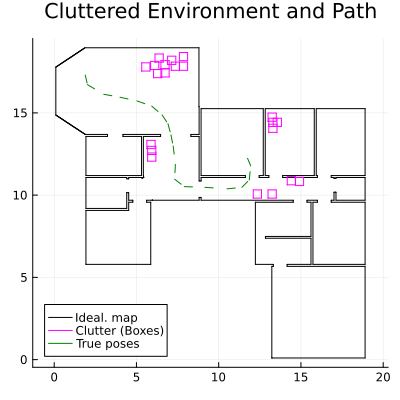

In [6]:
# -----------------------
mypl = plot(size=(400,400), aspect_ratio=:equal, title="Cluttered Environment and Path")
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(_ps[[1]], c=:green, linewidth=1, label="True poses")
plot!(_ps[2:end], c=:green, linewidth=1, label=nothing)
savefig("_imgs/loc_env_and_path.png")
mypl

### Creating the Obbservations along path

Note that the provided data does not include any measurement data. Therefore, we will take the measurements ourselves. In order to do so, we first have to include files containing deterministic depth sensors that enable us to make accurate measurements. Additionally, we have the option to introduce some noise to these measurements. 

In a different version, we might utilize an alternative observation and noise model, such as the sensor model defined below.

In [ ]:
#nbx
include("../src/cuda_raycaster_line_map_b.jl")

In [8]:
methods(cast)
@doc cast

# 2 methods for generic function "cast":
[1] cast(ps::Array, segs::Array; fov, num_a, zmax) in Main at /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/src/cuda_raycaster_line_map_b.jl:278
[2] cast(ps_::CuArray, segs_::CuArray; fov, num_a, zmax) in Main at /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/src/cuda_raycaster_line_map_b.jl:289

In [11]:
#nbx
"""
    zs, _as, ys = create_observations(ps::Vector{Pose}, segs, fov, num_a, obs_noise=0.0)
    
Return depth measurements `zs` and the angles `_as` along which the measuremnts were taken, 
and their 2D point cloud version `ys` for a given set of poses `ps` and a map `segs` of line
segments.

Example:
```julia
_obs_noise = 0.1
_fov       = 2π
_num_a     = 361
_zs, _as, _ys   = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)
```
"""
function create_observations(ps::Vector{Pose}, segs, fov, num_a, obs_noise=0.0)
    segs = stack(Vector.(segs));
    ps   = stack(Vector.(ps));

    zs  = cast(ps, segs; fov=fov, num_a=num_a)
    zs += _obs_noise * randn(size(zs))
    zs  = unstack(zs);

    as  = [range(-fov/2, fov/2, _num_a)...];
    ys  = [polar_inv(z,as) for z in zs]
    return zs, as, ys
end

create_observations

In [12]:
#nbx
_obs_noise = 0.1
_fov   = 2π
_num_a = 361
# Todo: This should be computed in the data file, but 
#       it also depens on `fov` so ...whatever
_zs, _as, _ys = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)

# -------------
println("Created a few new variables:\n")
summarize_vars(:(_obs_noise, _fov, _as, _zs, _ys))
println("")

Created a few new variables:

_obs_noise Float64
_fov       Float64
_as        Vector{Float64}
_zs        Vector{Vector{Float64}}
_ys        Vector{Vector{Vector{Float64}}}


[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/loc_data_gen.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/loc_data_gen.gif")
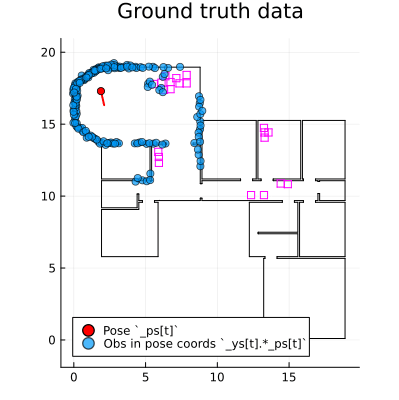

In [13]:
_bb = bounding_box(_segs)

# -----------------------
ani = Animation()
for t=1:1:_T
    p = _ps[t]
    y = _ys[t]

    agent_plt = plot(
        size=(400,400), aspect_ratio=:equal, title="Ground truth data", 
        xlim=(_bb[1][1]-1, _bb[2][1]+1),
        ylim=(_bb[1][2]-2, _bb[2][2]+2)
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!(_boxes, c=:magenta, label=nothing)
    plot!(p, c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(shuffle(y[1:2:end]).*p, c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")

    frame(ani, agent_plt)
end
gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)

### Task input to the model

The agent's objective is to accurately localize itself on an idealized map based on:
- The observations (`_zs` and `_as`; or the Euclidean version `_ys`).
- The idealized map itself (`_segs`).
- A perturbed version of the controls (`_us_noisy`), which we construct below.

In [14]:
#nbx
function perturb(u::Control, x_noise, hd_noise)
    dx  = u.dx  + diagnormal([0.,0.], [x_noise, x_noise])
    dhd = u.dhd + normal(0, hd_noise)
    return Control(dx,dhd)
end

perturb (generic function with 1 method)

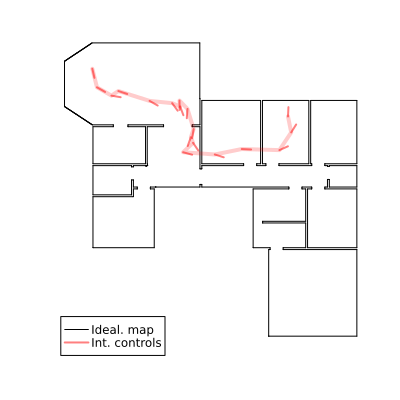

In [15]:
#nbx
x_noise  = 0.5
hd_noise = 5/360*2π
us_noisy = perturb.(_us, x_noise, hd_noise);

rel_ps = [p+u for (p,u) in zip(_ps[1:end-1],us_noisy)];
ps_noisy = [_ps[1]]
for u in us_noisy
    push!(ps_noisy, ps_noisy[end] + u)
end

# -----------------
env_plt = plot(
    size=(400,400), aspect_ratio=:equal, axis=false, grid=false,
    xlim=(_bb[1][1]-1, _bb[2][1]+1),
    ylim=(_bb[1][2]-2, _bb[2][2]+2),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!([p.x for p in ps_noisy], c=:red, label=nothing, alpha=0.2, linewidth=4)

plot!(ps_noisy[1],     c=:red,  r=.6, label="Int. controls", alpha=0.5, linewidth=2)
plot!(ps_noisy[2:end], c=:red,  r=.6,  label=nothing,  alpha=0.5, linewidth=2)
savefig("_imgs/loc_noisy_contr.png")
env_plt

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/loc_task_input.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/loc_task_input.gif")
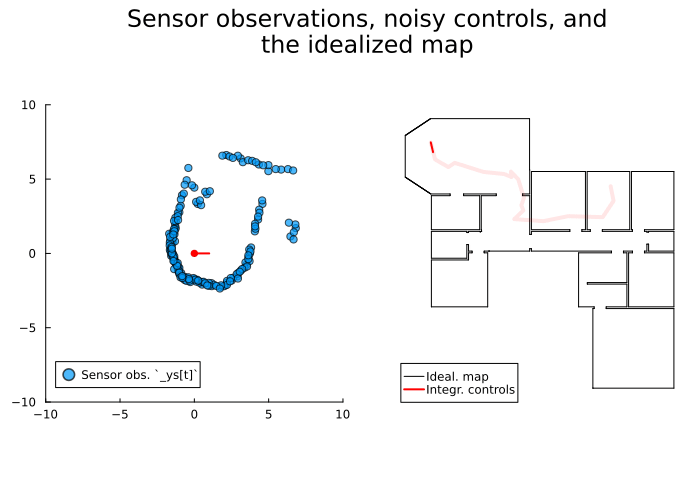

In [16]:
# -----------------------
myplts = []
ani = Animation()
for t=1:1:_T
    p = _ps[t]
    y = _ys[t]

    env_plt = plot(
        size=(300,300), aspect_ratio=:equal, axis=false, grid=false,
        xlim=(_bb[1][1]-1, _bb[2][1]+1),
        ylim=(_bb[1][2]-2, _bb[2][2]+2),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
    plot!([p.x for p in ps_noisy], c=:red, label=nothing, alpha=0.1, linewidth=4)
    plot!(ps_noisy[t], c=:red, r=.7,  label="Integr. controls", linewidth=2)


    ego_plt = plot(
        size=(300,300), aspect_ratio=:equal, grid=false,
        xlim=(-10,10),
        ylim=(-10,10),
        legend=:bottomleft,
    )
    plot!(Pose(), c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([zeros(2)], c=:red, markerstrokewidth=0, label=nothing)
    scatter!(shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Sensor obs. `_ys[t]`")

    frame(ani, plot(ego_plt, env_plt, layout=grid(1, 2), size=(700,500), plot_title="Sensor observations, noisy controls, and\nthe idealized map",  grid=false))
end
gif(ani, "_imgs/loc_task_input.gif", fps=2) # gif(ani, fname, fps=10)

## Key components of the model

Graphical model of probabilistic SLAM:

```julia
     1        2        3                t      

             u[1]     u[2]      ...    u[t-1]    observed
              |        |                 |        
    p[1] --- p[2] --- p[3] ---  ... --- p[t] 
     |        |        |                 |
    y[1]     y[2]     y[3]      ...     y[t]     observed
     |        |        |                 |
     m        m        m                 m       observed (in contrast to SLAM)
```



### Control Prior &mdash; $p(u)$

We don't use the prior at the moment. We assume the controls are given. But could be easily included in the model.

In [17]:
#nbx
@gen function control_prior_model(dx_noise=0.25, dhd_noise=45/360*2π)
    dx  ~ diagnormal([0;0], [dx_noise, dx_noise])
    dhd ~ normal(0, dhd_noise)
    return Control(dx, dhd)
end;

### Pose-prior model

In [19]:
#nbx
"""
    p = pose_prior_model(p=nothing, x_noise=0.25, hd_noise=45.)

Model depends on global variable `_bb`.
"""
@gen function pose_prior_model(p=nothing, x_noise=0.25, hd_noise=45/360*2π, bb=_bb)
    # Todo: better signature would be to ask if p is pose or a bounding box
    if p == nothing
        x  ~ mvuniform(bb...)
        hd ~ uniform(0,2π)
    else
        x  ~ diagnormal(p.x, [x_noise, x_noise])
        hd ~ normal(p.hd, hd_noise)
    end
    return Pose(x, hd)
end;

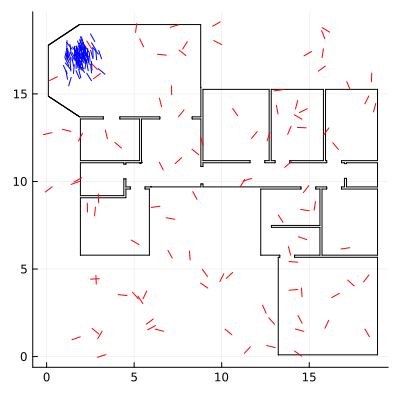

In [20]:
ps = [pose_prior_model(nothing) for t=1:100]
qs = [pose_prior_model(_ps[1], .5, 15/360*2π) for t=1:100]

# ----------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
plot!(ps,c=:red)
plot!(qs,c=:blue)

### Motion model

In [21]:
#nbx
"""
    q = motion_model(p, u, x_noise, hd_noise)

Sample a new pose `q` given the previous pose `p`, 
some control data `u = Control(dx, dhd)`, and noise levels
`x_noise` and `hd_noise`.
"""
@gen function motion_model(p, u, x_noise, hd_noise)
    dx, dhd = u.dx, u.dhd
    x   ~ diagnormal(p.x  + dx , [x_noise, x_noise])
    hd  ~ normal(p.hd + dhd, hd_noise)
    return Pose(x, hd)
end;

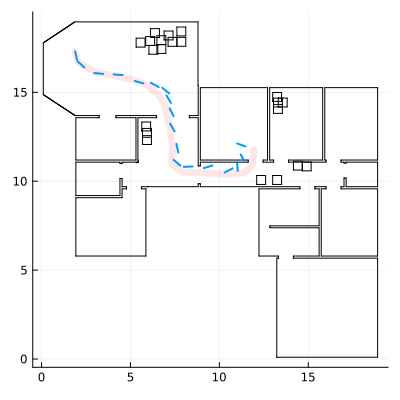

In [22]:
ps = Pose[_ps[1]]

for u in _us
    p = motion_model(ps[end], u, 1e-1, 2\pi * 1e-1)       
    push!(ps, p)
end
ps = [p for p in ps]

# ---------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black, linewidth=1)
plot!(_boxes, c=:black, linewidth=1)
plot!([p.x for p in _ps], c=:red, linewidth=7, alpha=0.1)
plot!(ps, c=col[1], linewidth=2)

### Sensor model

The sensor model will be based on
 - `cast` &mdash; a CUDA accelerated deterministic raycaster for point clouds, 
 - `get_2d_mixture_components` &mdash; a method to compute the 2dp3 mixture components, and
 - `sensodist_cu` &mdash; a sensor distribution implementing the 2dp3-likelihood.
  
By running the cell below we will include these methods; you can display more detailed description of each by calling `@doc` on them.

We will then proceed by defining the sensor model.

In [23]:
methods(cast)

# 2 methods for generic function "cast":
[1] cast(ps::Array, segs::Array; fov, num_a, zmax) in Main at /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/src/cuda_raycaster_line_map_b.jl:278
[2] cast(ps_::CuArray, segs_::CuArray; fov, num_a, zmax) in Main at /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/src/cuda_raycaster_line_map_b.jl:289

In [24]:
#nbx
include("src/sensor_distribution.jl")

(500, 500, 41)


  237.974 ms (500021 allocations: 207.90 MiB)


#### Plug and play version

Build the 2dp3 likelihood combining already defined Gen distributions and types... This explicit but slow...

In [25]:
gm = HomogeneousMixture(diagnormal, [1, 1])

HomogeneousMixture{Vector{Float64}}(GenDistributionZoo.DiagonalNormal(), [1, 1])

In [26]:
@gen function data_outlier_model(ỹ, sig, outlier, zmax)
    outlier ~ bernoulli(outlier)

    if outlier
        x ~ diagnormal([0.;0.],[zmax;zmax])
    else
        m = size(ỹ,1)
        x ~ gm(fill(1/m, m), ỹ', fill(sig, 2, m))
    end  
    return x, outlier
end;

mapped_data_model = Gen.Map(data_outlier_model);

In [27]:
ỹ = rand(361, 21, 2)
sig         = 0.1
outlier     = 0.1
zmax        = 100.

n,m, = size(ỹ)
args = map(a->fill(a, n), (sig, outlier, zmax))
args = (selectdim.([ỹ], [1], 1:n), args...)

tr = simulate(mapped_data_model, args);
ch = get_choices(tr)

│
├── 1
│   │
│   ├── :outlier : true
│   │
│   └── :x : [-53.44164283855925, 55.196029694758266]
│
├── 2
│   │
│   ├── :outlier : false
│   │
│   └── :x : [0.6722854936097019, 0.7432130367252218]
│
├── 3
│   │
│   ├── :outlier : false
│   │
│   └── :x : [-0.1659217028416943, 0.3988327158918044]
│
├── 4
│   │
│   ├── :outlier : false
│   │
│   └── :x : [0.21121588329001617, 0.5974843256680182]
│
├── 5
│   │
│   ├── :outlier : false
│   │
│   └── :x : [0.12380601046873452, 0.78034596170769]
│
├── 6
│   │
│   ├── :outlier : true
│   │
│   └── :x : [-183.77948092447954, -76.55179607303657]
│
├── 7
│   │
│   ├── :outlier : false
│   │
│   └── :x : [0.22119521486863153, 0.24383270466025497]
│
├── 8
│   │
│   ├── :outlier : false
│   │
│   └── :x : [0.414718572253181, 0.2664685265007527]
│
├── 9
│   │
│   ├── :outlier : false
│   │
│   └── :x : [0.2740044660533868, 0.13506877045692384]
│
├── 10
│   │
│   ├── :outlier : false
│   │
│   └── :x : [0.6056913010448757, 0.3906891618179058]
│
├── 1

In [28]:
@btime simulate(mapped_data_model, args) samples=3 evals=3;
@btime generate(mapped_data_model, args, ch) samples=3 evals=3;

  16.628 ms (164666 allocations: 7.14 MiB)
  17.222 ms (168198 allocations: 7.17 MiB)


In [93]:
@gen function sensor_model_v0(p, segs, w, sig, outlier, outlier_vol, zmax)
    p_    = CuArray(Vector(p))
    ps_   = reshape(p_, 1, 3)
    segs_ = CuArray(stack(Vector.(segs)))
    as_ = CuArray(_as) 

    zs_ = cast(ps_, segs_; fov=_fov, num_a=_num_a)    
    ỹ_  = get_2d_mixture_components(zs_, as_, w)[1,:,:,:]
    ỹ   = Array(ỹ_)

    n,m, = size(ỹ)
    args = map(a->fill(a, n), (sig, outlier, zmax))
    args = (selectdim.([ỹ], [1], 1:n), args...)
    data ~ mapped_data_model(args...);
    return data
end;

In [29]:
gm             = HomogeneousMixture(diagnormal, [1, 1])
outlier_dist   = diagnormal
sensor_mix     = HeterogeneousMixture([gm, outlier_dist])
sensor_product = ProductDistribution(sensor_mix)

# Todo: Ideally I could wrap this distribution into a type that allows
#       for changes to the signature and replacing the logpdf.

# Creating the arguments is tedious, here's a helper that
# makes it less painful
function sensor_product_args(ỹ, sig, outlier, outlier_vol, zmax) 
    n,m, = size(ỹ)
    ỹ_perm = permutedims(ỹ, (1,3,2))
    args = (
        fill([1-outlier, outlier], n), 
        fill(1/m, n, m), 
        ỹ_perm, 
        fill(sig, n, 2,m), 
        fill(0.0, n,2), 
        fill(zmax, n,2)
    )
    return args
end

ỹ = rand(361, 21, 2)
sig         = 0.1
outlier     = 0.1
outlier_vol = 100.
zmax        = 100.
args = sensor_product_args(ỹ, sig, outlier, outlier_vol, zmax) 
x = sensor_product(args...)

@btime sensor_product($args...) samples=3 evals=3;
@btime logpdf($sensor_product, $x, $args...) samples=3 evals=3;

  2.598 ms (16917 allocations: 1.02 MiB)
  16.285 ms (161736 allocations: 5.66 MiB)


Runtimes of the plug-and-play sensor distribution `sensor_product`:
```julia
 2.909 ms (17940 allocations: 1.07 MiB)
17.092 ms (163181 allocations: 5.77 MiB)
```



In [30]:
@gen function sensor_model_v1(p, segs, w, sig, outlier, outlier_vol, zmax)
    p_    = CuArray(Vector(p))
    ps_   = reshape(p_, 1, 3)
    segs_ = CuArray(stack(Vector.(segs)))
    as_ = CuArray(_as) 

    zs_ = cast(ps_, segs_; fov=_fov, num_a=_num_a)    
    ỹ_  = get_2d_mixture_components(zs_, as_, w)[1,:,:,:]
    ỹ   = Array(ỹ_)

    args = sensor_product_args(ỹ, sig, outlier, outlier_vol, zmax) 
    x ~ sensor_product(args...)
    
    return x
end;

In [31]:
t = 7

p  = _ps[t]
the_map = _segs

w            = 5
s_noise      = 0.2
outlier      = 0.1
outliver_vol = 100.0
zmax         = 100.0

args  = (p, the_map, w, s_noise, outlier, outliver_vol, zmax)
sensor_model_v1(args...)
tr = simulate(sensor_model_v1, args);
get_choices(tr)

│
└── :x : [[Inf, Inf], [-5.289638676355381, -0.4088360811408941], [-5.106915100478081, -0.2592701663750563], [-5.567035700336461, -0.6212806411465239], [-5.344673679868044, -0.7730528539739158], [-5.0930023744116495, -0.3248929565961902], [-4.768305455957684, 0.09263646533697428], [-5.0194949390547645, -0.5653003988131212], [-5.539830180930204, -0.5035164048360478], [-5.608287591584807, -1.4335837586261284], [-5.870055005189543, -1.415038574993316], [-6.295164991906477, -1.2727808757203827], [-5.884974051029016, -1.2181333220507038], [-5.413224826276109, -0.8433350373361467], [-5.647330576319028, -0.8206125450157731], [-6.065941515749823, -2.2531351294361306], [-6.021122408535179, -2.1952190238527765], [-5.925213595442797, -1.083696749423276], [-5.52718177429653, -1.5949820873259353], [-5.828674811529041, -2.1538238928680085], [-88.15065558407193, 45.90739369801175], [188.40585770251266, -25.76511525291525], [-5.614603588740036, -1.9274486895327558], [-6.265031214468311, -2.7867404851

In [33]:
t = 7

p  = _ps[t]
the_map = _segs

w            = 5
s_noise      = 0.2
outlier      = 0.1
outlier_vol = 100.0
zmax = 100


args  = (p, the_map, w, s_noise, outlier, outlier_vol, zmax)
x  = sensor_model_v1(args...)
ch = choicemap(:x => x)

@btime sensor_model_v1($args...)              samples=5 evals=5;
@btime simulate($sensor_model_v1, $args)      samples=5 evals=5;
@btime generate($sensor_model_v1, $args, $ch) samples=5 evals=5;

  2.935 ms (18074 allocations: 1.09 MiB)
  12.499 ms (111190 allocations: 4.28 MiB)
  10.463 ms (94278 allocations: 3.46 MiB)


Difference between `simulate` and `generate` comes from the additional sampling time. Both need to evaluate.

```julia
  2.441 ms (17352 allocations: 1.01 MiB)
  12.194 ms (110495 allocations: 4.20 MiB)
  10.197 ms (93567 allocations: 3.38 MiB)
```

#### Customized version

Use a custom Gen distribution `sensordist_cu` to define a more performant version of the above sensor model. 

In [34]:
@doc sensordist_cu

```julia
    x = sensordist_cu(ỹ_::CuArray, sig, outlier, outlier_vol=1.0)::Vector{Vector{Float64}}
```

Distribution from the 2dp3-likelihood. Takes 2d-mixture components `ỹ_` and samples a vector `x` of 2d points.

Arguments:

  * `ỹ_`: 2d-mixture components `(n,m,2)`
  * ...

Returns:

  * `x`: Observation vector of 2d points.


In [35]:
#nbx
@gen function sensor_model(p, segs, w, s_noise, outlier, outlier_vol, zmax=100.0)
    segs_ = CuArray(stack(Vector.(_segs)))
    p_    = CuArray(Vector(p))
    ps_   = reshape(p_, 1, 3)

    zs_      = cast_cu(ps_, segs_; fov=_fov)
    as_      = CuArray(_as)
    y_tilde_ = get_2d_mixture_components(zs_, as_, w)[1,:,:,:]

    x ~ sensordist_cu(y_tilde_, s_noise, outlier, outlier_vol)    
    return x
end;

In [36]:
ỹ = rand(361, 21, 2)
sig         = 0.1
outlier     = 0.1
outlier_vol = 100.
zmax        = 100.

ỹ_   = CuArray(ỹ)
args = (ỹ_, sig, outlier, outlier_vol) 
x = sensordist_cu(args...)

@btime sensordist_cu($args...)              samples=3 evals=3;
@btime logpdf($sensordist_cu, $x, $args...) samples=3 evals=3;

  11.797 ms (16349 allocations: 764.97 KiB)
  435.908 μs (592 allocations: 52.20 KiB)


In [38]:
t = 7

p  = _ps[t]
m  = _segs

w            = 5
s_noise      = 0.2
outlier      = 0.1
outlier_vol = 100.0
zmax = 100

args  = (p, m, w, s_noise, outlier, outlier_vol, zmax)
x  = sensor_model(args...)
ch = choicemap(:x => x)

@btime sensor_model($args...)              samples=5 evals=5;
@btime simulate($sensor_model, $args)      samples=5 evals=5;
@btime generate($sensor_model, $args, $ch) samples=5 evals=5;

  12.477 ms (17631 allocations: 865.33 KiB)
  13.589 ms (18007 allocations: 909.42 KiB)
  1.124 ms (1714 allocations: 151.83 KiB)


Difference between `simulate` and `generate` comes from the additional sampling time. Both need to evaluate.

```julia
  12.123 ms (17611 allocations: 864.49 KiB)
  12.556 ms (18097 allocations: 913.45 KiB)
  1.074 ms (1714 allocations: 152.14 KiB)
```

  12.288 ms (17672 allocations: 867.25 KiB)
  13.266 ms (18243 allocations: 919.97 KiB)
  1.155 ms (1730 allocations: 152.58 KiB)


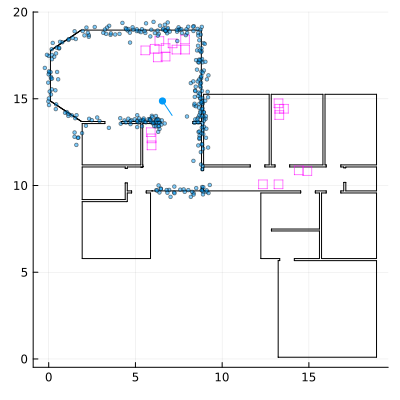

In [39]:
t = 7

p  = _ps[t]
m  = _segs

w            = 5
s_noise      = 0.2
outlier      = 0.1
outliver_vol = 100.0

args  = (p, m, w, s_noise, outlier, outliver_vol)

tr = simulate(sensor_model, args)
x = tr[]

ch = choicemap(:x => x)

@btime sensor_model(args...)            samples=3 evals=3;
@btime simulate(sensor_model, args)     samples=3 evals=3;
@btime generate(sensor_model, args, ch) samples=5 evals=5;

# -------------------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
plot!(_boxes, c=:magenta, alpha=0.5)
scatter!(x.*_ps[t], c=col[1], alpha=0.5, markersize=2)
scatter!(_ps[t], c=col[1])